<a href="https://colab.research.google.com/github/WoradeeKongthong/stock_price_time_series/blob/master/17_stockPrice_univariate_LSTM_multiStepOutput_vectorModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM (vector output model) : time series forcasting with 1 feature input and multi-steps output**
Any kind of LSTM can be used.  
- vanilla LSTM
- stacked LSTM
- bidirectional LSTM
- CNN LSTM
- Conv LSTM

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Dataset : google stock price (2015-2019) from yahoo.com

In [2]:
df = data.DataReader('GOOG', data_source='yahoo', start='2015-01-01', end='2019-12-31')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680


In [3]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680
...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,1343.560059
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,1360.400024
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,1351.890015


#  Get X from Dataframe
Time series to train the model is the 'Close' price.  

In [4]:
data = df.loc[:, ['Close']].values

In [5]:
data.shape

(1258, 1)

# Data Preprocessing

In [6]:
# Feature Scaling on the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0,1))
data_scaled = sc.fit_transform(data)

In [7]:
# check the shape of preprocessed data
print(data_scaled.shape)
data_scaled

(1258, 1)


array([[0.03698029],
       [0.0244395 ],
       [0.01078684],
       ...,
       [0.98933292],
       [0.97122881],
       [0.97224035]])

# Create timestep sequence
X : n_steps sequence of data  
y : 1 step output

In [8]:
def create_sequence(data, n_steps_in, n_steps_out):
  X = []
  y = []
  for i in range(n_steps_in, len(data)-n_steps_out+1):
    X.append(data[i - n_steps_in:i])
    y.append(data[i : i + n_steps_out])
  return np.array(X), np.array(y)

In [9]:
# choose number of timesteps
n_steps_in = 60
n_steps_out = 3
# Create the sequence and the output
X,y = create_sequence(data_scaled, n_steps_in, n_steps_out)
y = y.reshape(y.shape[0], y.shape[1])
n_features = X.shape[2]
print('X shape : ',X.shape)
print('y shape : ',y.shape)

X shape :  (1196, 60, 1)
y shape :  (1196, 3)


In [10]:
print(X[0], '==>', y[0])

[[0.03698029]
 [0.0244395 ]
 [0.01078684]
 [0.00980102]
 [0.01161222]
 [0.00414966]
 [0.        ]
 [0.00416113]
 [0.00953737]
 [0.01059198]
 [0.01780232]
 [0.01644967]
 [0.02921971]
 [0.04796196]
 [0.05433553]
 [0.04890201]
 [0.02989603]
 [0.02000327]
 [0.02075982]
 [0.04811105]
 [0.04118724]
 [0.04205846]
 [0.03463028]
 [0.04015557]
 [0.04407599]
 [0.04044216]
 [0.05088509]
 [0.04977316]
 [0.05775158]
 [0.06472121]
 [0.05764838]
 [0.05404893]
 [0.05768276]
 [0.05318922]
 [0.0451191 ]
 [0.04991074]
 [0.05882914]
 [0.07213788]
 [0.07548511]
 [0.09031852]
 [0.09295505]
 [0.09264552]
 [0.09489232]
 [0.08612869]
 [0.08746415]
 [0.07159914]
 [0.06720873]
 [0.07217225]
 [0.06278394]
 [0.07102595]
 [0.06681893]
 [0.07674606]
 [0.07501512]
 [0.07773192]
 [0.0759551 ]
 [0.08900025]
 [0.07592647]
 [0.07178253]
 [0.06395319]
 [0.06818308]] ==> [0.06356339 0.05732741 0.04926879]


# LSTM vector model
Any kind of LSTM can be used.  
- vanilla LSTM
- stacked LSTM
- bidirectional LSTM
- CNN LSTM
- Conv LSTM

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.


In [12]:
# define stacked LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(units=64, activation='relu'))
model.add(Dense(units=n_steps_out))
model.compile(optimizer='adam', loss='mse')

In [13]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 64)            16896     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 50,115
Trainable params: 50,115
Non-trainable params: 0
_________________________________________________________________


# Train the model

In [14]:
history = model.fit(X, y, epochs = 200, verbose = 0)

training loss :  0.12100341086303909


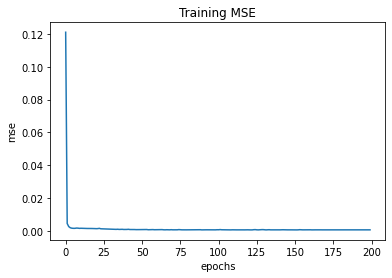

In [15]:
score = history.history['loss'][0]
print('training loss : ', score)

plt.plot(history.history['loss'])
plt.title('Training MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

In [16]:
y_pred = model.predict(X)

# inverse transform the price
y = sc.inverse_transform(y[:,0].reshape(len(y),1))
temp_list = []
for i in range(n_steps_out):
  temp = y_pred[:,i].reshape(len(y_pred),1)
  temp = sc.inverse_transform(temp)
  temp_list.append(temp)
y_pred_inv = np.concatenate(temp_list, axis=1)

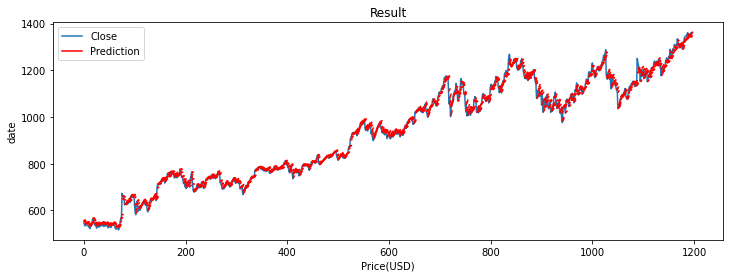

In [17]:
# plot the whole result
plt.figure(figsize=(12,4))
plt.plot(y)
for i in range(len(y_pred_inv)):
  plt.plot(np.arange(i, i+n_steps_out), y_pred_inv[i], c='red')
plt.title('Result')
plt.xlabel('Price(USD)')
plt.ylabel('date')
plt.legend(['Close', 'Prediction'])
plt.show()

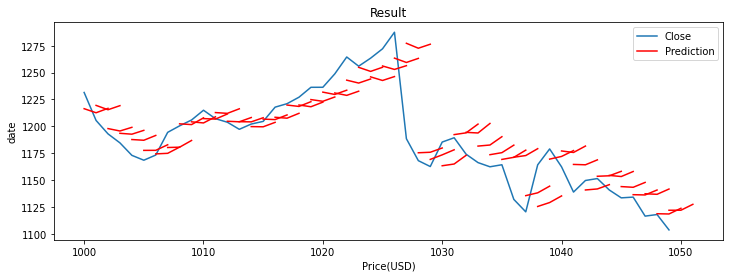

In [18]:
# plot the selected days of dataset
start_day = 1000
end_day = 1050

plt.figure(figsize=(12,4))
plt.plot(np.arange(start_day, end_day),y[start_day: end_day])
for i in range(start_day, end_day):
  plt.plot(np.arange(i, i+n_steps_out), y_pred_inv[i], c='red')
plt.title('Result')
plt.xlabel('Price(USD)')
plt.ylabel('date')
plt.legend(['Close', 'Prediction'])
plt.show()